In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics

In [2]:
df = pd.read_csv('Top_lane.csv')
lane = df.drop(columns = ['Lane', 'Unnamed: 0', 'Summoner', 'Item_0', 'Item_1', 'Item_2', 'Item_3', 'Item_4', 'Item_5', 'Item_6'])

In [3]:
lane.head()

,Champion,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,champion_name
0,86,4,3,9,3,1,12374,3836,2547,26232,8472,14,0,12,31,Garen
1,92,9,7,1,4,1,15022,3893,692,22422,11106,15,3,20,26,Riven
2,39,6,10,3,3,2,17448,3386,2879,34884,14624,17,5,19,10,Irelia
3,266,4,8,3,0,1,18326,12718,6744,30262,10812,15,6,26,19,Aatrox
4,31,3,4,2,3,1,13311,1453,745,23144,8896,13,1,13,66,Chogath


# Lots of champions can be played in any lane due to one trick players getting auto-filled. So to make sure my clustering is built on sufficient data, I am filtering out champions who are played less than 5 times in this role.

In [4]:
for champ in list(lane.groupby('Champion').count().query("Kills < 5").index):
    lane = lane[lane['Champion'] != champ]                           

In [5]:
lane = lane.groupby("Champion").mean()

In [6]:
lane.head()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Champion,,,,,,,,,,,,,,
2,6.270471,4.824648,6.133995,3.251447,1.531844,14381.842018,19519.489661,2312.845327,25512.636890,10620.894955,13.299421,3.421009,23.865178,11.836228
6,5.866667,4.431579,4.936842,3.235088,1.501754,14803.828070,7969.870175,3099.638596,20139.428070,10557.989474,13.873684,1.996491,20.147368,19.178947
8,4.811801,4.382503,5.179044,2.514751,1.357070,17359.970498,5700.062055,2689.551373,24090.948118,10212.516785,13.963377,1.886063,16.782299,3.326551
10,4.510526,5.431579,6.242105,2.200000,1.347368,15872.552632,8771.226316,3764.315789,20482.821053,10838.752632,13.936842,1.410526,19.289474,7.357895
14,3.209945,5.232044,7.038674,1.441989,1.044199,12995.834254,4829.248619,2996.232044,27392.790055,9223.419890,13.779006,1.817680,17.546961,34.701657


# To determine the optimal amount of clusters, I am going to run a loop of various K values and plot the errors to pick the ideal number of clusters based on where the "elbow" is.

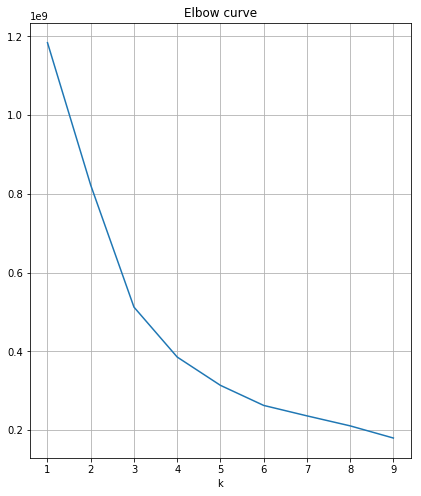

In [7]:
distorsions = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(lane)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('k')
plt.plot(range(1, 10), distorsions)
plt.grid(True)

There is no clear "elbow" here to easily determine the ideal number of clustes. As such, I am going to use the silhouette plot to determine the ideal number of clusters based on this data.

In [8]:
silhouette_plot = []
for k in range(2, 10):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(lane)
    silhouette_avg = metrics.silhouette_score(lane, cluster_labels)
    silhouette_plot.append(silhouette_avg)

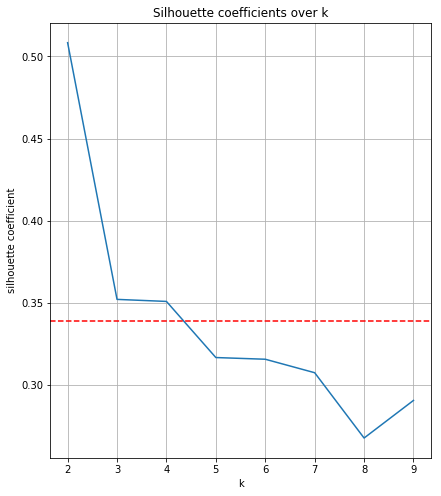

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 10), silhouette_plot)
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

The highest point, which also happens to be the second "elbow" is at 6 clusters and so I will use that to further analyze the playstyles in the bot lane.

In [21]:
k_means = KMeans(n_clusters = 4).fit(lane.groupby('Champion').mean())
cluster_assignments = k_means.predict(lane.groupby('Champion').mean())

In [22]:
cluster_assignments

array([2, 1, 0, 1, 0, 1, 2, 1, 3, 0, 0, 0, 1, 0, 3, 0, 0, 3, 1, 0, 3, 3,
       0, 1, 1, 0, 3, 3, 0, 2, 0, 0, 1, 1, 0, 0, 0, 0, 0, 3], dtype=int32)

In [23]:
clustered = lane.groupby('Champion').mean()

In [24]:
clustered['Cluster'] = cluster_assignments

In [25]:
clustered.groupby("Cluster").count()['Kills']

Cluster
0    19
1    10
2     3
3     8
Name: Kills, dtype: int64

There are 5 champions in Cluster 0, 4 champions in cluster 1, 6 champions in cluster 2, and ONLY 1 champion in cluster 3. 

In [26]:
clustered.groupby("Cluster").mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,4.662904,4.972937,5.380533,2.358406,1.286442,14836.899486,6665.628455,3359.852975,24848.561812,10009.423950,13.693988,1.728013,17.391723,20.676021
1,4.826588,4.847850,5.487744,2.457752,1.299150,16614.412039,8597.806923,4041.062273,18759.252041,10565.572019,13.872296,1.858563,19.548434,15.028595
2,6.202017,5.080859,5.227834,3.048789,1.457451,14831.864555,17612.171426,3922.774555,25620.848162,11072.864636,13.764979,2.123762,23.054777,9.976502
3,4.142325,4.832729,6.908325,2.099381,1.187080,13297.603103,4945.327869,2171.562051,19775.932082,9357.804579,13.457788,2.135710,19.924628,24.336800


# Based on the average values of the clusters above, it looks like the one champion in Cluster 2 had an outlier performance where the values are drastically different from every other cluster.

In [27]:
champion_names = 'http://ddragon.leagueoflegends.com/cdn/9.13.1/data/en_US/champion.json?fbclid=IwAR3wpqEjCmWqLKToVoMwWz-iGVCkHaVVfVOWtvy9OpfKrM7Hjt1YZ4VyPk8'

df = pd.read_json(champion_names)

champs = []
ids = []
for names in list(df['data']):
    champs.append(names['id'])
    ids.append(names['key'])

champ_dict = {}

for champ in range(len(champs)):
    champ_dict[ids[champ]] = champs[champ]

clustered['champion_name'] = clustered.index.map(lambda x: champ_dict[str(x)] )



In [32]:
clustered[clustered['Cluster'] == 3]

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls,Cluster,champion_name
Champion,,,,,,,,,,,,,,,,
27,3.202346,5.046921,6.545455,1.571848,1.058651,13397.721408,3763.850440,2066.266862,22325.624633,9504.612903,13.835777,1.202346,17.826979,30.337243,3,Singed
54,3.250000,5.260417,6.229167,1.442708,1.088542,12922.536458,3615.026042,1796.567708,17716.916667,8675.276042,13.338542,1.333333,16.375000,27.703125,3,Malphite
68,5.180297,4.655204,6.998141,2.653346,1.361524,16877.310409,5346.749071,1611.289963,18412.554833,9861.040892,13.645911,2.877323,19.009294,11.790892,3,Rumble
78,3.959427,4.589499,6.536993,2.093079,1.119332,13922.062053,5784.570406,2526.706444,21357.002387,9372.353222,13.570406,2.455847,21.202864,26.966587,3,Poppy
80,5.532075,5.652830,6.777358,2.754717,1.330189,13155.705660,6279.956604,2295.139623,17632.877358,9460.243396,12.907547,2.445283,22.226415,16.837736,3,Pantheon
92,5.880342,4.769231,4.458689,3.105413,1.475783,14173.972934,6983.018519,3152.237179,19946.132479,10741.508547,14.039886,1.576923,17.075499,23.708689,3,Riven
98,3.072193,4.114973,9.160428,1.663102,1.034759,10377.085561,3611.687166,1594.564171,19843.911765,8753.240642,13.417112,2.237968,20.393048,24.096257,3,Shen
516,3.061920,4.572755,8.560372,1.510836,1.027864,11554.430341,4177.764706,2329.724458,20972.436533,8494.160991,12.907121,2.956656,25.287926,33.253870,3,Ornn


# 

In [33]:
clustered.groupby('Cluster').mean()

,Kills,Deaths,Assists,Killing_Spree,Multikills,Total_Damage,Damage_To_Objectives,Damage_To_Turrets,Damage_Taken,Gold_Earned,Champ_Level,Wards_Bought,Vision_Score,Crowd_Controls
Cluster,,,,,,,,,,,,,,
0,4.662904,4.972937,5.380533,2.358406,1.286442,14836.899486,6665.628455,3359.852975,24848.561812,10009.423950,13.693988,1.728013,17.391723,20.676021
1,4.826588,4.847850,5.487744,2.457752,1.299150,16614.412039,8597.806923,4041.062273,18759.252041,10565.572019,13.872296,1.858563,19.548434,15.028595
2,6.202017,5.080859,5.227834,3.048789,1.457451,14831.864555,17612.171426,3922.774555,25620.848162,11072.864636,13.764979,2.123762,23.054777,9.976502
3,4.142325,4.832729,6.908325,2.099381,1.187080,13297.603103,4945.327869,2171.562051,19775.932082,9357.804579,13.457788,2.135710,19.924628,24.336800
